LSTM/Transformer Short-Term Price Forecast

Goal: Predict the next 1-hour BTC price using sequence models.
Input: OHLCV data + trend signal from XGBoost (optional as extra feature).
Output: Forecasted price (or normalized return) for the next 1-hour candle.

Imports + Data Load

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Load cleaned OHLCV data
df = pd.read_csv("data/processed/ohlc_clean.csv", index_col=0, parse_dates=True)

# Optional: load trend classifier (XGBoost)
# xgb_model = joblib.load("../models/xgboost_trend_model.pkl")

print(df.head())


                               open      high       low     close      volume
Open time                                                                    
2018-01-01 00:00:00+00:00  13715.65  13715.65  13400.01  13529.01  443.356199
2018-01-01 01:00:00+00:00  13528.99  13595.89  13155.38  13203.06  383.697006
2018-01-01 02:00:00+00:00  13203.00  13418.43  13200.00  13330.18  429.064572
2018-01-01 03:00:00+00:00  13330.26  13611.27  13290.00  13410.03  420.087030
2018-01-01 04:00:00+00:00  13434.98  13623.29  13322.15  13601.01  340.807329


 Add Features
 Price returns, trend (from XGBoost), moving averages, volatility, etc.
 Normalize features for LSTM.

In [3]:
# Example: add return as target
df['return_1'] = df['close'].pct_change()
df.dropna(inplace=True)

# Optional: add trend signal as feature
# df['trend_signal'] = xgb_model.predict_proba(features)[:,1]

# Features for LSTM
features = ['open','high','low','close','volume']  # add more if desired
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Save scaler for later inverse transform
joblib.dump(scaler, "../models/lstm_scaler.pkl")


['../models/lstm_scaler.pkl']

Build Sequences

In [4]:
def create_sequences(data, seq_length=24):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 3])  # 'close' column index in features
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (69307, 24, 5)
y shape: (69307,)


Train/Test Split

In [5]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (55445, 24, 5)
Test shape: (13862, 24, 5)


Build LSTM Model

In [7]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\AN515-55\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [10]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 2.2807e-04 - val_loss: 1.6239e-05
Epoch 2/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 2.0266e-04 - val_loss: 1.6143e-05
Epoch 3/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 2.0223e-04 - val_loss: 2.0325e-05
Epoch 4/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 2.1254e-04 - val_loss: 8.2095e-05
Epoch 5/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 2.1547e-04 - val_loss: 3.4877e-05
Epoch 6/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 1.9769e-04 - val_loss: 2.2935e-05
Epoch 7/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 1.9639e-04 - val_loss: 4.2028e-05
Epoch 8/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 2.0581e-04 - val_loss: 2.5391e-05
Epoch 9/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 2.0302e-04 - val_loss: 1.6311e-05
Epoch 10/100
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 1.8267e-04 - val_loss: 3.7453e-05
Epoch 11/

Evaluate & Forecast

434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


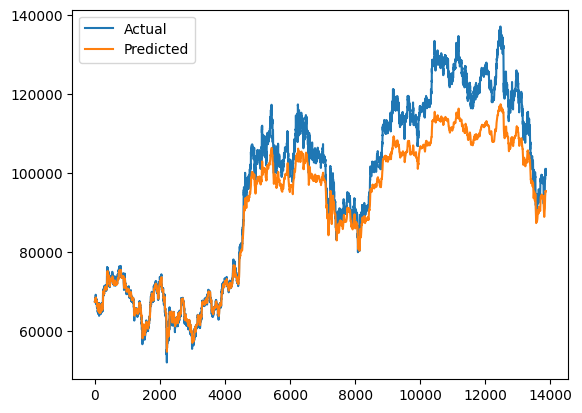

In [11]:
y_pred = model.predict(X_test)

# If you want to convert back to original scale
y_test_scaled = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), len(features)-1)), y_test.reshape(-1,1)], axis=1)
)[:,-1]
y_pred_scaled = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), len(features)-1)), y_pred], axis=1)
)[:,-1]

import matplotlib.pyplot as plt
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_pred_scaled, label='Predicted')
plt.legend()
plt.show()


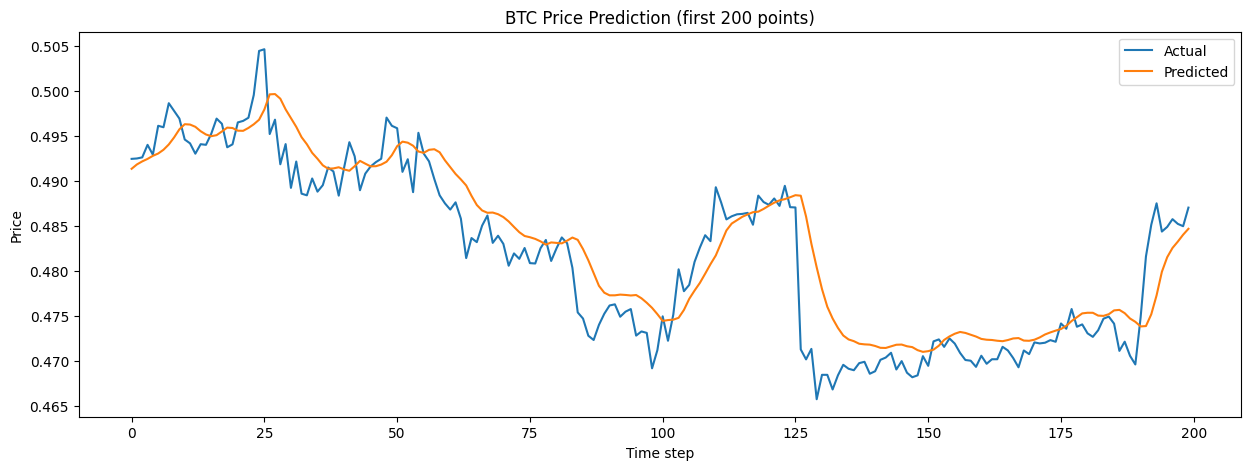

In [12]:
plt.figure(figsize=(15,5))
plt.plot(y_test[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.title('BTC Price Prediction (first 200 points)')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()


In [14]:
y_pred = model.predict(X_test)

# Calculate common regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)


434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
MSE: 0.002996234095925727
MAE: 0.04123729106279484
R2 Score: 0.8893791862465668


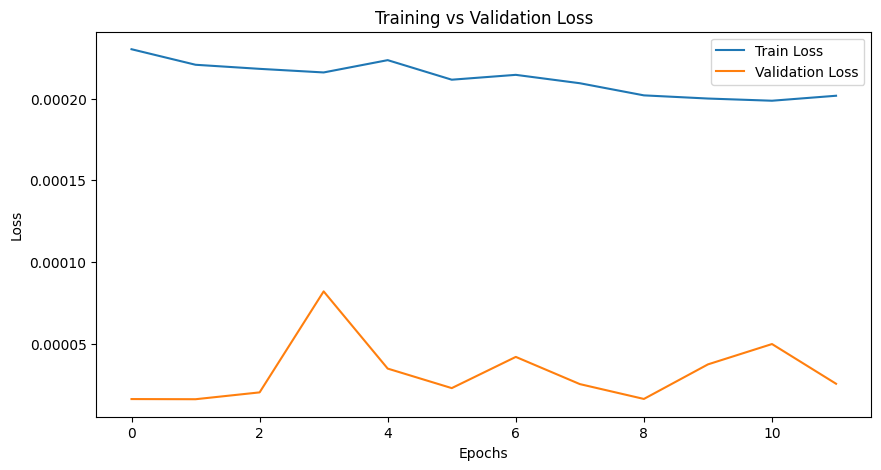

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


Save model


In [16]:
# Save trained LSTM
model.save("models/lstm_price_model.h5")

# Later, you can load it like this:
# from tensorflow.keras.models import load_model
# model = load_model("models/lstm_price_model.h5")
